In [192]:
# import Pkg; Pkg.add("Interpolations")

In [193]:
using Plots
using DataFrames
using CSV
using Tables
using Interpolations
using Statistics

# Generate data
* either generate the data
* OR read it from csv

In [194]:
# my_function = (x)-> x^2+x
# my_function_r = (x)-> (x+2.5)^2-2 .+ rand(1)[1]*0.1
function get_data()
    filename = "mydata.csv"
    if isfile(filename)==false
        println("generating data")
        ee = 0.1
        x = collect(-1-ee:0.01:1+ee)
        y = x.^2;
        # y += rand(Float32, size(x)[1])*0.05;
        y += sin.(pi*2*x*4)*0.05
        df = DataFrame((x=x, y  =y));
        CSV.write(filename, df)
    else
        println("Reading file")
        df = DataFrame(CSV.File(filename));
        x = df[!,"x"];
        y = df[!, "y"];
    end
    return x,y
end

get_data (generic function with 1 method)

In [195]:
xpoints, ypoints = get_data()

Reading file


([-1.1, -1.09, -1.08, -1.07, -1.06, -1.05, -1.04, -1.03, -1.02, -1.01  …  1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1], [1.18061, 1.14957, 1.12116, 1.09579, 1.0737, 1.05495, 1.03938, 1.02667, 1.01631, 1.00767  …  1.03253, 1.06449, 1.09513, 1.12382, 1.15005, 1.1735, 1.19401, 1.21164, 1.22663, 1.23939])

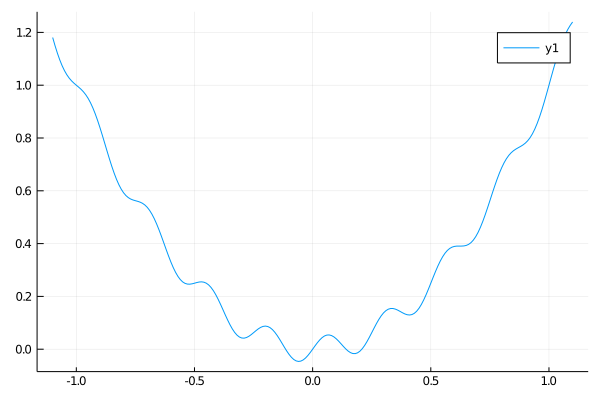

In [196]:
plot(xpoints,ypoints)

In [197]:
x=1:0.25:5
y = log.(x);

In [198]:
x2 = 1:0.1:5
interp_linear = LinearInterpolation(x,y);

In [199]:
y2 = interp_linear.(x2);

In [200]:
size(y2)

(41,)

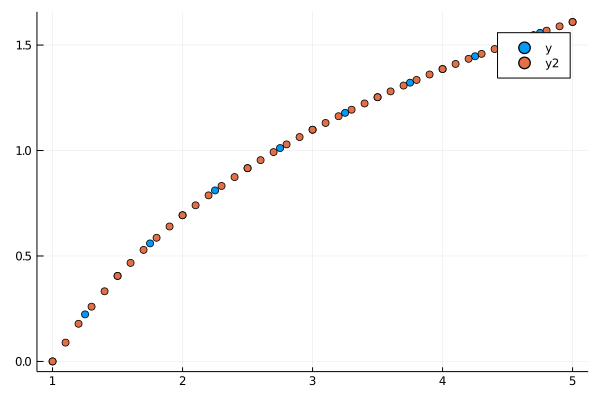

In [201]:
scatter(x,y, label = "y")
scatter!(x2,y2, label = "y2")


In [202]:
n = size(y2)[1]
n

41

In [203]:
last_n = 5
mean(y2[n-last_n:n])

1.5573124399817324

In [204]:
function mean_of_last_items(loss_values, last_n = 5)
    # get the average of the last 5 items in the list
    n = size(loss_values)[1]
    if n<5
        return 1
    else
        return mean(loss_values[n-last_n:n])
    end
end

mean_of_last_items (generic function with 2 methods)

In [205]:
function numerical_derivative(f, x, dx=0.001) 
    derivative = (f(x+dx) - f(x-dx))/(2*dx) 
    return derivative 
end 

numerical_derivative (generic function with 2 methods)

In [206]:
function x_still_changing(x_values)
    if length(x_values)<6
        return true
    end
    m = mean_of_last_items(x_values)
    v = last(x_values)
    diff = abs(m-v)
    if diff<1e-4
        return false
    else
        return true
    end
end

x_still_changing (generic function with 1 method)

In [207]:
function make_inter_function(x,y)
    interp_linear = LinearInterpolation(x,y);
    return interp_linear
end

make_inter_function (generic function with 1 method)

In [208]:
f = make_inter_function(xpoints,ypoints);

In [209]:
f(0.1)

0.039389262614623666

In [210]:
function find_a_min_grad(funct_input, start = 1)
    x_i = start 
    step = 1e-1
    x_list = []
    push!(x_list, x_i)
    for i in range(1,length = 3000)     
        dydx = numerical_derivative(funct_input, x_i)
        if x_still_changing(x_list) == false
            println("Found a min at $x_i. Iteration $i")
            return x_i,x_list
        end     
        x_delta = -dydx*step # step in the negative gradient
        x_i = x_i+x_delta      
        push!(x_list, x_i)
    end
    println("Did NOT terminate. x =  $x_i")
    return x_i,x_list
end

find_a_min_grad (generic function with 2 methods)

In [211]:
x, xs = find_a_min_grad(f);

Did NOT terminate. x =  -0.12859631929102155


In [215]:
function plot_optimization_results(xs, f)
    ys = f.(xs);
    scatter(xs,ys, lw = 4, title = "Evaluted points values a function of iteration #")
    plot!(xs,ys, label = "Path")
    plot!(xpoints,ypoints, label = "True", legend = :outertopleft)
end

plot_optimization_results (generic function with 1 method)

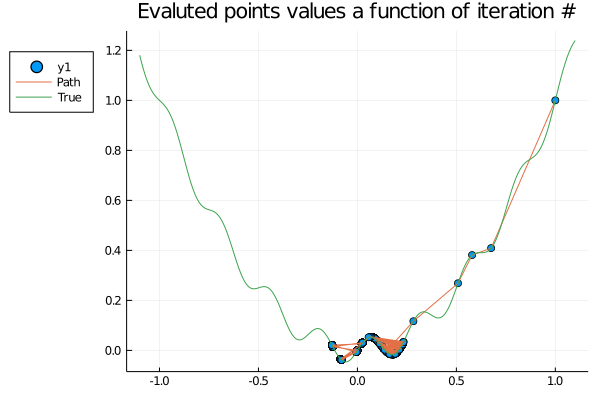

In [212]:
plot_optimization_results(xs, f)

In [213]:
function find_a_min_momentum(funct_input, start = 1)
    x_i = start 
    # println("argmin is $idx with x value of $x_i")
    step = 1e-1
    m_t = 0
    m_t_minus_1 = 0
    beta = 0.5
    eps_ = 1e-7
    x_list = []
    push!(x_list, x_i)
    for i in range(1,length = 3000)
        # println("$x_i and $i")
        # get the gradient
        # dydx = f_dydx(x_i)
        dydx = numerical_derivative(funct_input, x_i)
        if x_still_changing(x_list) == false
            println("Found a min at $x_i. Iteration $i")
            return x_i,x_list
        end
        m_t = beta*m_t_minus_1+(1-beta)*dydx
        x_delta = -m_t*step # step in the negative gradient
        x_i = x_i+x_delta
        m_t_minus_1 = m_t
        push!(x_list, x_i)
    end
    println("Did NOT terminate. x =  $x_i")
    return x_i,x_list
end

find_a_min_momentum (generic function with 2 methods)

In [214]:
# @time x, xs = find_a_min_momentum(f);
x, xs = find_a_min_momentum(f);


Found a min at 0.1762470474123651. Iteration 65


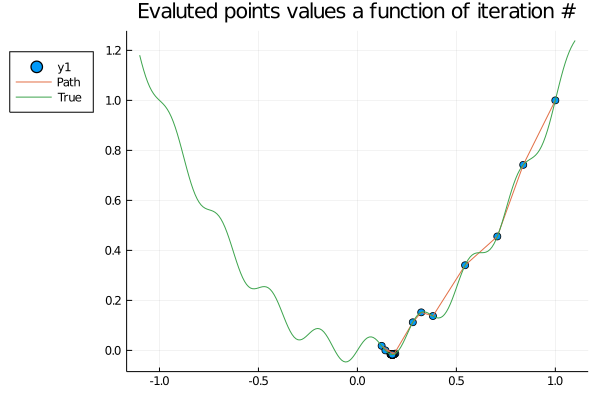

In [216]:
plot_optimization_results(xs, f)


In [217]:
function find_a_min_rmsp(funct_input, start = 1)   
    x_i = start 
    step = 1e-1 # basically the learning rate. 
    v_t = 0
    v_t_minus_1 = 0
    beta = 0.7
    eps_ = 1e-7
    x_list = []
    push!(x_list, x_i)
    for i in range(1,length = 3000)
        # get the gradient
        # dydx = f_dydx(x_i)
        dydx = numerical_derivative(funct_input, x_i)
        if x_still_changing(x_list) == false
            println("Found a min at $x_i. Iteration $i")
            return x_i,x_list
        end
        # m_t = beta*m_t_minus_1+(1-beta)*dydx
        v_t = beta*v_t_minus_1 +(1-beta)*dydx^2
        update_term = 1/(v_t+1e-9)*dydx
        x_delta = -update_term*step # step in the negative gradient
        x_i = x_i+x_delta
        v_t_minus_1 = v_t
        push!(x_list, x_i)

    end

    println("Did NOT terminate. x =  $x_i")
    return x_i,x_list
end

find_a_min_rmsp (generic function with 2 methods)

In [218]:
x, xs = find_a_min_rmsp(f);

Did NOT terminate. x =  -0.01397470394170007


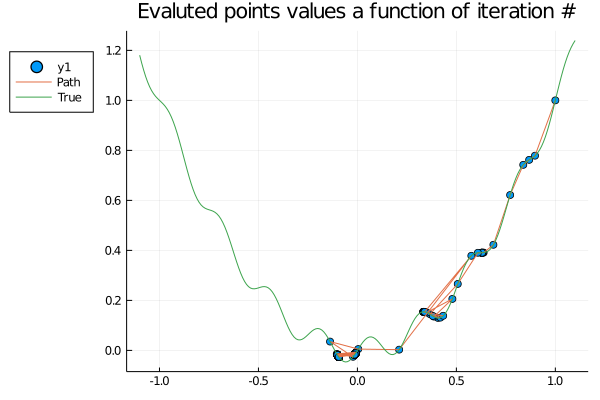

In [219]:
plot_optimization_results(xs, f)

In [220]:
function find_a_min_adam(funct_input, start = 1)   
    x_i = start # trial_x[idx] # x sub i 
    step = 1e-1 # basically the learning rate. 
    v_t = 0
    v_t_minus_1 = 0
    beta_1 = 0.9
    beta_2 = 0.9
    eps_ = 1e-7
    x_list = []
    for i in range(1,length = 3000)
        # get the gradient
        dydx = numerical_derivative(funct_input, x_i)
        if x_still_changing(x_list) == false
            println("Found a min at $x_i. Iteration $i")
            return x_i,x_list
        end
        # m_t = beta*m_t_minus_1+(1-beta)*dydx
        v_t = beta*v_t_minus_1 +(1-beta)*dydx^2
        update_term = 1/(v_t+1e-9)*dydx
        x_delta = -update_term*step # step in the negative gradient
        x_i = x_i+x_delta
        v_t_minus_1 = v_t
        push!(x_list, x_i)


    end

    println("Did NOT terminate. x =  $x_i")
    return x_i,x_list
end

find_a_min_adam (generic function with 2 methods)

In [221]:
# @doc range(length=200)
for i in range(1,length = 3)
    print(i)
end

123

In [222]:
x_list = []

0-element Array{Any,1}

In [223]:
@doc push

No documentation found.

Binding `push` does not exist.


In [224]:
# code_native(f, (Any,)) 